In [1]:
import numpy as np
import scipy as sp
import pickle as pkl
import networkx as nx
from py2neo import Graph
import py2neo
import pandas as pd
import nxviz as nv
import matplotlib.pyplot as plt
from stellargraph import StellarGraph
from sklearn import metrics


%matplotlib inline

broker_nodes = pkl.load(open( "broker_nodes_brunosept.pkl", "rb" ))
cars_nodes = pkl.load(open( "cars_nodes_brunosept.pkl", "rb" ))
claims_nodes = pkl.load(open( "claims_nodes_brunosept.pkl", "rb" ))
policy_nodes = pkl.load(open( "policy_nodes_brunosept.pkl", "rb" ))
edges = pkl.load(open( "edges_brunosept.pkl", "rb" ))

labels = pd.DataFrame(pkl.load(open("Y", "rb")))
labels.rename(columns = {"y1": "Fraud", "y2":"Labelled"}, inplace = True)

HG = StellarGraph({"claim" : claims_nodes, "car" : cars_nodes, "policy" : policy_nodes, "broker" : broker_nodes}, edges)

HG_claims = HG.nodes("claim")
HG_cars = HG.nodes("car")
HG_sub = list(HG_claims)+ list(HG_cars)
adjmat_claim_car = HG.to_adjacency_matrix(HG_sub)[:len(HG_claims), len(HG_claims):]

HG_policies = HG.nodes("policy")
HG_sub = list(HG_cars)+list(HG_policies)
adjmat_car_policy = HG.to_adjacency_matrix(HG_sub)[:len(HG_cars), len(HG_cars):]

HG_brokers = HG.nodes("broker")
HG_sub = list(HG_policies) + list(HG_brokers)
adjmat_policy_broker = HG.to_adjacency_matrix(HG_sub)[:len(HG_policies), len(HG_policies):]

C = adjmat_claim_car
P = adjmat_car_policy
B = adjmat_policy_broker
CP = C @ P
CB = CP @ B

A_bipartite = sp.sparse.hstack((C, 
                                CP,
                                CB
                               )).tocsr()

C:\Users\bruno\anaconda3\lib\site-packages\nxviz\__init__.py:18: UserWarning: 
nxviz has a new API! Version 0.7.0 onwards, the old class-based API is being
deprecated in favour of a new API focused on advancing a grammar of network
graphics. If your plotting code depends on the old API, please consider
pinning nxviz at version 0.7.0, as the new API will break your old code.

To check out the new API, please head over to the docs at
https://ericmjl.github.io/nxviz/ to learn more. We hope you enjoy using it!

(This deprecation message will go away in version 1.0.)

  warnings.warn(


In [2]:
nRows = A_bipartite.shape[0]
edges = {"source":[], "target":[], "weight":[]}

from tqdm.notebook import tqdm
for i in tqdm(range(nRows)):
    nonzeroIndices = A_bipartite[i, :].nonzero()
    for j in nonzeroIndices[1]:
        w = A_bipartite[i,j]
        edges["source"].append(i)
        edges["target"].append(j)
        edges["weight"].append(w)

  0%|          | 0/396146 [00:00<?, ?it/s]

In [3]:
df_edges = pd.DataFrame(edges)
#df_edges.to_csv("BipartiteNetwork.csv")

In [4]:
party_index = np.concatenate((np.array(cars_nodes.index), np.array(policy_nodes.index), np.array(broker_nodes.index)
                             ))
pd_party_index = pd.DataFrame(party_index)
pd_party_index.columns = ["party"]
pd_party_index["party_num"] = range(len(party_index))

pd_claim_index = pd.DataFrame(claims_nodes.index)
pd_claim_index.columns = ["claim"]
pd_claim_index["claim_num"] = range(len(claims_nodes.index))

In [5]:
pd_merged = pd_claim_index.merge(df_edges.merge(pd_party_index, how = "left", left_on = "target", right_on = "party_num"), left_on = "claim_num", right_on = "source")
pd_merged = pd_merged[["claim", "party", "weight"]]
pd_merged.columns = ["source", "target", "weight"]
pd_merged.head()

,source,target,weight
0,000020211004303,267937.0,1.0
1,000020211004303,176593.0,1.0
2,000020211004303,010103007094831,1.0
3,000020211004303,70034001,1.0
4,000020211004304,127134.0,1.0


In [6]:
all_claims = pd.DataFrame(pd_claim_index['claim'])
all_claims.columns = ["ID"]
all_claims = all_claims.set_index("ID")

all_parties = pd.DataFrame(pd_party_index['party'])
all_parties.columns = ["ID"]
all_parties = all_parties.set_index("ID")

In [7]:
HG_bipartite = StellarGraph({"claim": all_claims, "party":all_parties},edges = pd_merged[["source", "target"]])

In [8]:
Nx_bipartite = HG_bipartite.to_networkx()

In [9]:
labels = pd.DataFrame(pkl.load(open("Y", "rb")))
labels.rename(columns = {"y1": "Fraud", "y2":"Labelled"}, inplace = True)

Below, claims are either red or green, depending on whether they are fraudulent or not.

Brokers are indicated in blue. 

The cars are purple and finally, the policies are yellow. 

  0%|          | 0/18 [00:00<?, ?it/s]

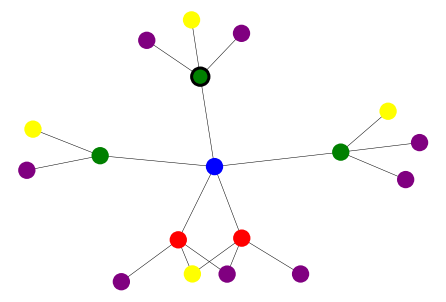

In [10]:
G = nx.generators.ego.ego_graph(Nx_bipartite, "000020121049339", radius = 10)

color_map = []
width_map = []
for node in tqdm(G):
    if node == "000020121049339":
        width_map.append(3)
    else:
        width_map.append(0)
    
    if node in claims_nodes.index:
        if labels[labels.index == node]["Fraud"][0] ==1:
            color_map.append('red')
        else:
            color_map.append('green')
    elif node in broker_nodes.index: 
        color_map.append('blue')    
    elif node in cars_nodes.index:
        color_map.append('purple')
    else:
        color_map.append('yellow')
nx.draw(G, node_color=color_map, width = 0.5, linewidths = width_map, edgecolors = 'black')
#plt.savefig("fraud_high.pdf")

In [11]:
G.nodes["000020121049339"]['label']

'claim'

In [12]:
G.nodes()

NodeView(('010102101026461', '000020161026049', '010102100655912', '000020161031321', '010502100593240', '010302100948501', '91032101       ', 145375.0, 218513.0, '000020181052723', '000020201025292', 4024.0, 18841.0, '000020121049339', 195870.0, 389693.0, 386302.0, 14815.0))

We plot a couple of different neighbourhoods.

In [13]:
fraud_claims_sample = labels[labels["Fraud"]== 1].sample(10, random_state=1997)
for claim in tqdm(fraud_claims_sample.index):
    color_map = []
    G = nx.generators.ego.ego_graph(Nx_bipartite, claim, radius = 2)
    for node in G:
        if node == claim:
            color_map.append("black")
        elif node in claims_nodes.index:
            if labels[labels.index == node]["Fraud"][0] ==1:
                color_map.append('red')
            else:
                color_map.append('green')
        elif node in broker_nodes.index: 
            color_map.append('blue')    
        elif node in cars_nodes.index:
            color_map.append('purple')
        else:
            color_map.append('yellow')
    nx.draw(G, node_color=color_map)
    plt.savefig("fraud"+claim+".pdf")
    plt.close()

  0%|          | 0/10 [00:00<?, ?it/s]

In [14]:
fraud_claims_sample

,Fraud,Labelled
SI01_NO_SIN,,
000020121050002,1,1.0
000020131034408,1,1.0
000020181041698,1,1.0
000020151007726,1,1.0
000020141044826,1,1.0
000020141018331,1,1.0
000020191046466,1,1.0
000020151003869,1,1.0
000020121004240,1,1.0


In [15]:
df_degree = pd.DataFrame(Nx_bipartite.degree(claims_nodes.index))

In [16]:
di = nx.degree_centrality(Nx_bipartite)
df_degcen = pd.DataFrame({'claim': [claim for claim in claims_nodes.index],
                          'degree': [di[claim] for claim in claims_nodes.index] })
df_degcen.head()

,claim,degree
0,000020211004303,0.000004
1,000020211004304,0.000003
2,000020211004306,0.000004
3,000020211004307,0.000004
4,000020211004308,0.000003


## Geodesic Distance 

Here, we change the graph a bit, since we don't want brokers in the network

In [17]:
A_bipartite = sp.sparse.hstack((C, 
                                CP
                               )).tocsr()

nRows = A_bipartite.shape[0]
edges = {"source":[], "target":[], "weight":[]}

from tqdm.notebook import tqdm
for i in tqdm(range(nRows)):
    nonzeroIndices = A_bipartite[i, :].nonzero()
    for j in nonzeroIndices[1]:
        w = A_bipartite[i,j]
        edges["source"].append(i)
        edges["target"].append(j)
        edges["weight"].append(w)
        
df_edges = pd.DataFrame(edges)

party_index = np.concatenate((np.array(cars_nodes.index), np.array(policy_nodes.index)))
pd_party_index = pd.DataFrame(party_index)
pd_party_index.columns = ["party"]
pd_party_index["party_num"] = range(len(party_index))

pd_merged = pd_claim_index.merge(df_edges.merge(pd_party_index, how = "left", left_on = "target", right_on = "party_num"), left_on = "claim_num", right_on = "source")
pd_merged = pd_merged[["claim", "party", "weight"]]
pd_merged.columns = ["source", "target", "weight"]

all_parties = pd.DataFrame(pd_party_index['party'])
all_parties.columns = ["ID"]
all_parties = all_parties.set_index("ID")

HG_bipartite = StellarGraph({"claim": all_claims, "party":all_parties},edges = pd_merged[["source", "target"]])

Nx_bipartite = HG_bipartite.to_networkx()

  0%|          | 0/396146 [00:00<?, ?it/s]

In [18]:
from BipartiteFunctions import geodesic

C:\Users\bruno\anaconda3\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [19]:
G = nx.generators.ego.ego_graph(Nx_bipartite, "000020121002644", radius = 5)
geo_G = geodesic(G); geo_G

,Item,Geodesic distance,Number of cycles
0,000020161007988,4,1
1,385969.0,4,1
2,000020161022170,4,1
3,011002100690914,4,2
4,172958.0,4,1
5,000020151010838,4,1
6,000020151026654,4,1


In [20]:
full_geo_G = geodesic(Nx_bipartite)

In [21]:
full_geo_G

,Item,Geodesic distance,Number of cycles
0,000020211004798,4,93
1,011002001945985,4,2257
2,000020211004274,4,230807
3,010102120000025,4,270153
4,000020211005472,4,94
...,...,...,...
447610,397662.0,4,1
447611,412776.0,4,1
447612,000020181041256,4,1
447613,010202100619748,4,1


In [22]:
full_geo_G = full_geo_G[full_geo_G["Item"].isin(claims_nodes.index)]
full_geo_G.head()

,Item,Geodesic distance,Number of cycles
0,000020211004798,4,93
2,000020211004274,4,230807
4,000020211005472,4,94
5,000020211005516,4,93
6,000020201034680,4,93


<AxesSubplot:>

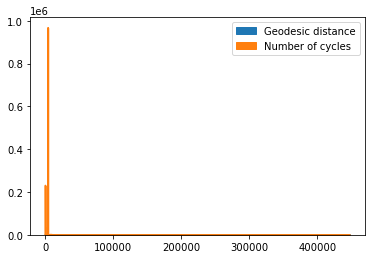

In [23]:
full_geo_G.plot.area()

In [24]:
df_geo_fraud = full_geo_G.merge(labels.reset_index(), left_on = "Item", right_on = "SI01_NO_SIN");
df_geo_fraud

,Item,Geodesic distance,Number of cycles,SI01_NO_SIN,Fraud,Labelled
0,000020211004798,4,93,000020211004798,0,0.0
1,000020211004274,4,230807,000020211004274,0,0.0
2,000020211005472,4,94,000020211005472,0,0.0
3,000020211005516,4,93,000020211005516,0,0.0
4,000020201034680,4,93,000020201034680,0,0.0
...,...,...,...,...,...,...
258783,000020121004616,4,1,000020121004616,0,0.0
258784,000020121008532,4,1,000020121008532,0,0.0
258785,000020141018727,4,1,000020141018727,0,0.0
258786,000020181041256,4,1,000020181041256,0,0.0


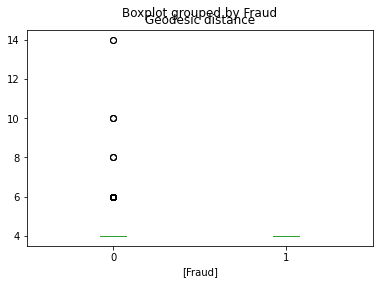

In [25]:
df_geo_fraud[["Geodesic distance", "Fraud"]].boxplot(by = ["Fraud"], grid = False)
plt.savefig("BoxplotFraudGeo.pdf")

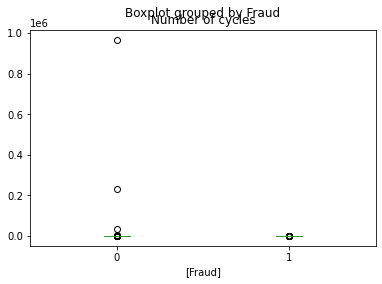

In [26]:
df_geo_fraud[["Number of cycles", "Fraud"]].boxplot(by = ["Fraud"], grid = False)
plt.savefig("BoxplotFraudCycle.pdf")

# Incorportate the BiRank and train-test split

In [10]:
import numpy as np
import scipy as sp
import pickle as pkl
import networkx as nx
from py2neo import Graph
import py2neo
import pandas as pd
import nxviz as nv
import matplotlib.pyplot as plt
from stellargraph import StellarGraph

from tqdm.notebook import tqdm

from BiRank import BiRank

%matplotlib inline

In [11]:
broker_nodes = pkl.load(open( "broker_nodes_brunosept.pkl", "rb" ))
cars_nodes = pkl.load(open( "cars_nodes_brunosept.pkl", "rb" ))
claims_nodes = pkl.load(open( "claims_nodes_brunosept.pkl", "rb" )).sort_values("ID")
policy_nodes = pkl.load(open( "policy_nodes_brunosept.pkl", "rb" ))
edges = pkl.load(open( "edges_brunosept.pkl", "rb" ))

labels = pd.DataFrame(pkl.load(open("Y", "rb"))).sort_values("SI01_NO_SIN")
labels.rename(columns = {"y1": "Fraud", "y2":"Labelled"}, inplace = True)

In [12]:
HG = StellarGraph({"claim" : claims_nodes, "car" : cars_nodes, "policy" : policy_nodes, "broker" : broker_nodes}, edges)

In [13]:
HG_claims = HG.nodes("claim")
HG_cars = HG.nodes("car")
HG_sub = list(HG_claims)+ list(HG_cars)
adjmat_claim_car = HG.to_adjacency_matrix(HG_sub)[:len(HG_claims), len(HG_claims):]

HG_policies = HG.nodes("policy")
HG_sub = list(HG_cars)+list(HG_policies)
adjmat_car_policy = HG.to_adjacency_matrix(HG_sub)[:len(HG_cars), len(HG_cars):]

HG_brokers = HG.nodes("broker")
HG_sub = list(HG_policies) + list(HG_brokers)
adjmat_policy_broker = HG.to_adjacency_matrix(HG_sub)[:len(HG_policies), len(HG_policies):]

In [14]:
C = adjmat_claim_car
P = adjmat_car_policy
B = adjmat_policy_broker
CP = C @ P
CB = CP @ B

adjmat_bipartite = sp.sparse.hstack((C, CP, CB))

fraud = {"FraudInd": labels["Fraud"].values}
fraudMat = pd.DataFrame(fraud)

claim_nodes = pd.DataFrame({"ID": HG_claims}).set_index("ID")

HG_parties = np.concatenate((HG_cars, HG_policies, HG_brokers))
party_nodes = pd.DataFrame({"ID": HG_parties}).set_index("ID")

In [15]:
ADJ = adjmat_bipartite.tocsr()
number_claims = ADJ.shape[0]
train_set_size = int(np.round(0.6*number_claims))
test_set_size = number_claims-train_set_size

fraud_train = {"FraudInd": labels["Fraud"].values[:train_set_size]}
fraudMat_train = pd.DataFrame(fraud_train)
test_set_fraud = {"FraudInd": [0]*test_set_size}
fraudMat_test_set = pd.DataFrame(test_set_fraud)
fraudMat_test = fraudMat_train.append(fraudMat_test_set)

ADJ = ADJ.transpose().tocsr()

Claims_res, Parties_res, aMat, iterations, convergence = BiRank(ADJ, claim_nodes, party_nodes, fraudMat_test)

C:\Users\bruno\OneDrive\Documenten\KUL\MaAct2\Thesis\Python\BiRank.py:6: RuntimeWarning: divide by zero encountered in true_divide
  Dp = sparse.diags(np.asarray(1 / np.sqrt(adjMat.sum(axis=1).flatten())), [0])
C:\Users\bruno\OneDrive\Documenten\KUL\MaAct2\Thesis\Python\BiRank.py:7: RuntimeWarning: divide by zero encountered in true_divide
  Dc = sparse.diags(np.asarray(1 / np.sqrt(adjMat.sum(axis=0))), [0])


Convergence reached.


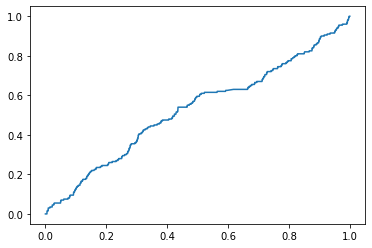

In [16]:
y = labels[train_set_size:].Fraud.values
pred = Claims_res.sort_values("ID")[train_set_size:].ScaledScore
fpr_bi, tpr_bi, thresholds = metrics.roc_curve(y,pred)
plt.plot(fpr_bi,tpr_bi)

In [33]:
BiRankScore = Claims_res.sort_values("ID")[["StdScore"]];
BiRankScore_index = BiRankScore.reset_index()
BiRankScore_index

,index,StdScore
0,0,-0.068859
1,1,-0.075079
2,2,-0.071438
3,3,-0.049342
4,4,-0.075863
...,...,...
396141,396141,0.424123
396142,396142,-0.096843
396143,396143,-0.072824
396144,396144,0.010491


In [34]:
Claims_res, Parties_res, aMat, iterations, convergence = BiRank(ADJ, claim_nodes, party_nodes, fraudMat_test, alpha = 0)
BiRankScore_vanilla = Claims_res.sort_values("ID")[["StdScore"]];
BiRankScore_vanilla_index = BiRankScore_vanilla.reset_index()
BiRankScore_vanilla_index.columns = ["index", "StdScoreVanilla"]
BiRankScore_vanilla_index

C:\Users\bruno\OneDrive\Documenten\KUL\MaAct2\Thesis\Python\BiRank.py:6: RuntimeWarning: divide by zero encountered in true_divide
  Dp = sparse.diags(np.asarray(1 / np.sqrt(adjMat.sum(axis=1).flatten())), [0])
C:\Users\bruno\OneDrive\Documenten\KUL\MaAct2\Thesis\Python\BiRank.py:7: RuntimeWarning: divide by zero encountered in true_divide
  Dc = sparse.diags(np.asarray(1 / np.sqrt(adjMat.sum(axis=0))), [0])


Convergence reached.


,index,StdScoreVanilla
0,0,-0.040352
1,1,-0.040352
2,2,-0.040352
3,3,-0.040352
4,4,-0.040352
...,...,...
396141,396141,-0.040352
396142,396142,-0.040352
396143,396143,-0.040352
396144,396144,-0.040352


In [25]:
from sklearn.ensemble import GradientBoostingClassifier

In [36]:
y = labels["Fraud"]; y

SI01_NO_SIN
000020111059354    0
000020111059939    0
000020121000009    0
000020121000011    0
000020121000015    0
                  ..
000020211007106    0
000020211007107    0
000020211007108    0
000020211007109    0
000020211007111    0
Name: Fraud, Length: 396146, dtype: int64

In [37]:
df_geo_fraud_index = df_geo_fraud.reset_index()

In [38]:
df_degcen

,claim,degree
0,000020211004303,0.000004
1,000020211004304,0.000003
2,000020211004306,0.000004
3,000020211004307,0.000004
4,000020211004308,0.000003
...,...,...
396141,000020211004295,0.000003
396142,000020211004296,0.000000
396143,000020211004300,0.000004
396144,000020211004301,0.000004


In [39]:
X = BiRankScore_index.merge(df_degcen.reset_index(), on = "index", how = "outer")
X = X.merge(BiRankScore_vanilla_index, on = "index", how = "outer")
X = X.merge(df_geo_fraud_index, left_on = "claim", right_on = "Item", how = "outer").sort_values("claim")
X = X[["StdScore", "StdScoreVanilla", "degree", "Geodesic distance", "Number of cycles"]].fillna(0);
X

,StdScore,StdScoreVanilla,degree,Geodesic distance,Number of cycles
2113,0.015079,-0.040352,0.000003,4.0,1.0
2114,0.065097,-0.040352,0.000003,4.0,1.0
2115,-0.078394,-0.040352,0.000003,0.0,0.0
2116,-0.084015,-0.040352,0.000003,4.0,1.0
2117,-0.086124,-0.040352,0.000004,4.0,1.0
...,...,...,...,...,...
2109,-0.010476,-0.040352,0.000004,0.0,0.0
2110,-0.069720,-0.040352,0.000003,4.0,1.0
2111,-0.067879,-0.040352,0.000003,4.0,1.0
2107,-0.088260,-0.040352,0.000134,4.0,93.0


In [40]:
X_train = X.iloc[:train_set_size]
y_train = y[:train_set_size]

X_test = X.iloc[train_set_size:]
y_test = y[train_set_size:]

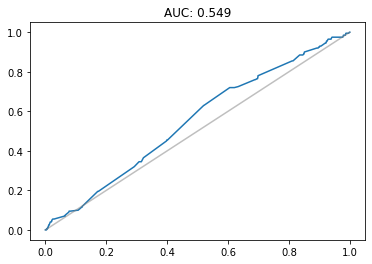

In [41]:
model = GradientBoostingClassifier(n_estimators=50)
model.fit(X_train,y_train)

y_pred_proba = model.predict_proba(X_test)
y_pred = y_pred_proba[:,1]

fpr, tpr, thresholds = metrics.roc_curve(y_test,y_pred)

plt.plot(fpr,tpr)
plt.plot([0,1], [0,1], color = "grey", alpha = 0.5)
plt.title("AUC: "+str(np.round(metrics.auc(fpr, tpr),3)))
plt.savefig("AUC_Transductive_5features.pdf")

In [10]:
from stellargraph.data import UniformRandomMetaPathWalk
from gensim.models import Word2Vec
import multiprocessing

C:\Users\bruno\anaconda3\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [11]:
metapaths = [
    ["claim", "car", "claim"],
    ["claim", "car","policy","car","claim"],
    ["claim",  "car","policy","broker","policy","car", "claim"]
]

In [12]:
metapaths

[['claim', 'car', 'claim'],
 ['claim', 'car', 'policy', 'car', 'claim'],
 ['claim', 'car', 'policy', 'broker', 'policy', 'car', 'claim']]

In [13]:
dimensions = 20
num_walks = 2
walk_length = 13 #Go from claim to claim via broker twice
context_window_size = 10

workers = multiprocessing.cpu_count()
print(workers)

rw = UniformRandomMetaPathWalk(HG)
walks = rw.run(
    HG.nodes(), n=num_walks, length=walk_length, metapaths=metapaths, seed = 123
)
print("Number of random walks: {}".format(len(walks)))

16
Number of random walks: 2376876


In [14]:
model = Word2Vec(
    walks,
    window=context_window_size,
    min_count=0,
    sg=1,
    workers=workers,
    vector_size=dimensions
)

node_ids = model.wv.index_to_key  # list of node IDs
node_embeddings = (
    model.wv.vectors
)  # numpy.ndarray of size number of nodes times embeddings dimensionality
node_targets = [HG.node_type(node_id) for node_id in node_ids]

In [15]:
#pd.DataFrame(walks).to_csv("randomWalks_npartite.csv")

In [16]:
labels

,Fraud,Labelled
SI01_NO_SIN,,
000020211004303,0,0.0
000020211004304,0,0.0
000020211004306,0,0.0
000020211004307,0,0.0
000020211004308,0,0.0
...,...,...
000020211004295,0,0.0
000020211004296,0,0.0
000020211004300,0,0.0


In [17]:
embedding_df = pd.DataFrame(node_embeddings)
embedding_df.index = node_ids
claim_embedding_df = embedding_df.loc[list(claims_nodes.index)]
embedding_fraud = claim_embedding_df.merge(labels, left_index=True, right_index=True)
embedding_fraud.sort_index(inplace = True)

In [18]:
train_size = int(round(0.6*len(embedding_fraud),0))

X_train = embedding_fraud.iloc[:train_size, :20]
y_train = embedding_fraud.iloc[:train_size, 20]

X_test = embedding_fraud.iloc[train_size:, :20]
y_test = embedding_fraud.iloc[train_size:, 20]

In [19]:
from sklearn.ensemble import GradientBoostingClassifier

In [24]:
embedding_model = GradientBoostingClassifier(n_estimators=100, subsample = 0.8,max_depth=2, random_state=1997, verbose = 1).fit(X_train, y_train)

      Iter       Train Loss      OOB Improve   Remaining Time 
         1           0.0375          -0.0011            1.40m
         2           0.0368           0.0003            1.36m
         3           0.0383          -0.0000            1.34m
         4           0.0372           0.0000            1.32m
         5           0.0374           0.0000            1.31m
         6           0.0372           0.0000            1.29m
         7           0.0374           0.0000            1.28m
         8           0.0374          -0.0000            1.27m
         9           0.0382          -0.0000            1.26m
        10           0.0372          -0.0000            1.25m
        20           0.0374          -0.0000            1.10m
        30           0.0372          -0.0013           56.68s
        40           0.0362           0.0000           48.14s
        50           0.0356           0.0000           39.90s
        60           0.0358           0.0000           31.87s
       

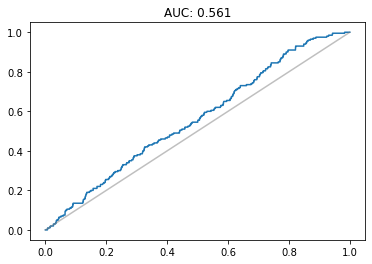

In [25]:
y_pred = embedding_model.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = metrics.roc_curve(y_test,y_pred)
plt.plot(fpr,tpr)
plt.plot([0,1], [0,1], color = "grey", alpha = 0.5)
plt.title("AUC: "+str(np.round(metrics.auc(fpr, tpr),3)))
plt.savefig("AUC_metapath_pitch.pdf")

In [64]:
X = BiRankScore_index.merge(df_degcen.reset_index(), on = "index", how = "outer")
X = X.merge(BiRankScore_vanilla_index, on = "index", how = "outer")
X = X.merge(df_geo_fraud_index, left_on = "claim", right_on = "Item", how = "outer").sort_values("claim")
X = X[["claim","StdScore", "StdScoreVanilla", "degree", "Geodesic distance", "Number of cycles"]].fillna(0)
X.set_index("claim", inplace = True)
X = X.merge(embedding_fraud, left_index = True, right_index = True)

,StdScore,StdScoreVanilla,degree,Geodesic distance,Number of cycles,0,1,2,3,4,...,12,13,14,15,16,17,18,19,Fraud,Labelled
claim,,,,,,,,,,,,,,,,,,,,,
000020111059354,0.015079,-0.040352,0.000003,4.0,1.0,-0.130797,0.456789,0.449923,0.247995,-0.472199,...,0.273202,0.063068,0.618694,0.092549,0.862550,0.063066,-0.973532,-0.053260,0,0.0
000020111059939,0.065097,-0.040352,0.000003,4.0,1.0,-0.594025,-0.313841,1.272519,0.067338,-0.508291,...,-0.518224,-0.095048,1.093315,0.299823,1.236074,0.547563,-0.346738,-0.673835,0,0.0
000020121000009,-0.078394,-0.040352,0.000003,0.0,0.0,0.016082,1.262875,0.427353,-0.089090,-0.755525,...,-0.141618,-0.292989,-0.035313,0.066281,0.190876,-0.482680,-0.528303,-1.555738,0,0.0
000020121000011,-0.084015,-0.040352,0.000003,4.0,1.0,0.009999,0.524252,1.088241,0.158074,-0.223546,...,-0.426811,0.191263,0.289504,0.608432,0.143248,-1.096324,-1.019708,-0.889711,0,0.0
000020121000015,-0.086124,-0.040352,0.000004,4.0,1.0,0.157540,0.522450,1.050192,0.028250,-0.714635,...,-0.433947,-0.284955,0.788764,0.414563,-0.239039,-0.346185,-0.862916,-0.381169,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
000020211007106,-0.010476,-0.040352,0.000004,0.0,0.0,-0.249085,0.397809,0.611531,0.927904,-0.259568,...,-0.171277,-0.199634,0.464123,0.339948,0.242356,0.090134,-0.384038,-0.204075,0,0.0
000020211007107,-0.069720,-0.040352,0.000003,4.0,1.0,-0.155327,0.217694,0.491820,0.129317,-0.416477,...,-0.002189,0.004128,0.515592,-0.449997,0.211060,-0.127408,-0.219511,-0.489204,0,0.0
000020211007108,-0.067879,-0.040352,0.000003,4.0,1.0,-0.578808,0.857570,1.656601,-0.327035,-0.406322,...,-0.376531,0.637794,0.511105,-0.583268,-0.006634,0.290544,-1.077538,0.201863,0,0.0


In [68]:
train_size = int(round(0.6*len(X),0))

X_train = X.iloc[:train_size, :25]
y_train = X.iloc[:train_size, 25]

X_test = X.iloc[train_size:, :25]
y_test = X.iloc[train_size:, 25]

      Iter       Train Loss      OOB Improve   Remaining Time 
         1           0.0374          -0.0000            1.49m
         2           0.0368           0.0000            1.49m
         3           0.0383          -0.0000            1.48m
         4           0.0371           0.0000            1.47m
         5           0.0373           0.0000            1.47m
         6           0.0370          -0.0013            1.45m
         7           0.0373           0.0000            1.44m
         8           0.0373           0.0000            1.44m
         9           0.0381          -0.0000            1.43m
        10           0.0371           0.0000            1.41m
        20           0.0372          -0.0000            1.23m
        30           0.0371          -0.0000            1.08m
        40     6286518.3313           0.0000           54.86s
        50           0.0358          -0.0000           45.40s
        60     6286518.3299          -0.0000           36.20s
       

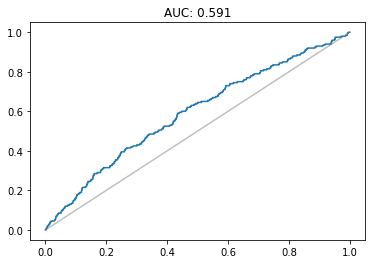

In [70]:
model =  GradientBoostingClassifier(n_estimators=100, subsample = 0.8,max_depth=2, random_state=1997, verbose = 1).fit(X_train, y_train)

y_pred_proba = model.predict_proba(X_test)
y_pred = y_pred_proba[:,1]

fpr, tpr, thresholds = metrics.roc_curve(y_test,y_pred)

plt.plot(fpr,tpr)
plt.plot([0,1], [0,1], color = "grey", alpha = 0.5)
plt.title("AUC: "+str(np.round(metrics.auc(fpr, tpr),3)))
plt.savefig("AUC_Transductive_25features.pdf")

## Distribution AUC of metapath2vec

In this part, we do the random walks a couple of times to see the difference in AUC. This will give us a feeling of the distribution and stability of these random walks.

This serves as additional insights into the strengths and weeknesses of this procedure.

In [48]:
from BipartiteFunctions import Metapath2vec

In [49]:
dimensions = 20
num_walks = 1
walk_length = 13 #Go from claim to claim via broker twice
context_window_size = 10

metapaths = [
    ["claim", "car", "claim"],
    ["claim", "car","policy","car","claim"],
    ["claim",  "car","policy","broker","policy","car", "claim"]
]

AUC = []

for i in tqdm(range(15)):
    node_ids, node_embeddings, node_targets = Metapath2vec(HG, 
                                                           metapaths, 
                                                           dimensions = dimensions, 
                                                           num_walks = num_walks, 
                                                           walk_length = walk_length)
    
    embedding_df = pd.DataFrame(node_embeddings)
    embedding_df.index = node_ids
    claim_embedding_df = embedding_df.loc[list(claims_nodes.index)]
    embedding_fraud = claim_embedding_df.merge(labels, left_index=True, right_index=True)
    embedding_fraud.sort_index(inplace = True)
    
    train_size = int(round(0.6*len(embedding_fraud),0))

    X_train = embedding_fraud.iloc[:train_size, :20]
    y_train = embedding_fraud.iloc[:train_size, 20]

    X_test = embedding_fraud.iloc[train_size:, :20]
    y_test = embedding_fraud.iloc[train_size:, 20]
    
    embedding_model = GradientBoostingClassifier(n_estimators=100, 
                                                 subsample = 0.8,
                                                 max_depth=2, 
                                                 random_state=1997).fit(X_train, y_train)
    
    y_pred = embedding_model.predict_proba(X_test)[:,1]
    fpr, tpr, thresholds = metrics.roc_curve(y_test,y_pred)
    AUC.append(metrics.auc(fpr, tpr))

  0%|          | 0/15 [00:00<?, ?it/s]

Number of random walks: 1188438
Number of random walks: 1188438
Number of random walks: 1188438
Number of random walks: 1188438
Number of random walks: 1188438
Number of random walks: 1188438
Number of random walks: 1188438
Number of random walks: 1188438
Number of random walks: 1188438
Number of random walks: 1188438
Number of random walks: 1188438
Number of random walks: 1188438
Number of random walks: 1188438
Number of random walks: 1188438
Number of random walks: 1188438


In [50]:
AUC

[0.5793837910247823,
 0.5978371393547246,
 0.5680235912244563,
 0.543151894375008,
 0.5345292181121966,
 0.592146937279632,
 0.5886078112954796,
 0.5422844974661628,
 0.5524450106787651,
 0.590954975419884,
 0.5768501908276359,
 0.5595676995791682,
 0.5512592096450101,
 0.5642425975306146,
 0.5859172838023987]

(array([1., 2., 2., 1., 1., 1., 1., 1., 3., 2.]),
 array([0.53452922, 0.54086001, 0.5471908 , 0.55352159, 0.55985239,
        0.56618318, 0.57251397, 0.57884476, 0.58517556, 0.59150635,
        0.59783714]),
 <BarContainer object of 10 artists>)

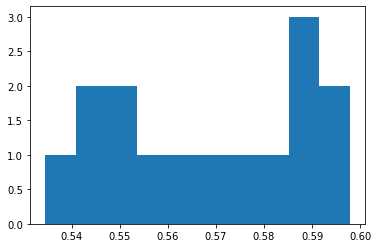

In [51]:
plt.hist(AUC)

(array([3., 3., 2., 2., 5.]),
 array([0.53452922, 0.5471908 , 0.55985239, 0.57251397, 0.58517556,
        0.59783714]),
 <BarContainer object of 5 artists>)

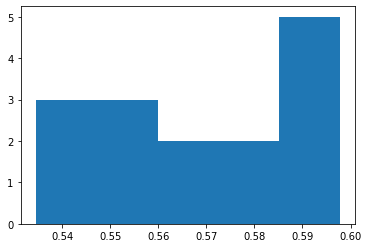

In [52]:
plt.hist(AUC,bins=5)

In [53]:
np.mean(AUC)

0.5684801231743946

In [54]:
np.std(AUC)

0.019927991782278717

In [57]:
min(AUC)

0.5345292181121966

In [58]:
max(AUC)

0.5978371393547246

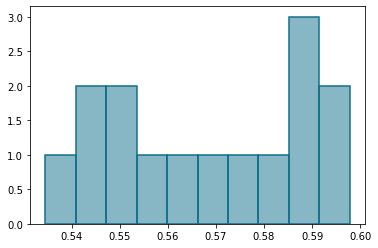

In [77]:
KULbg = "#116E8A" 
plt.hist(AUC, color = KULbg, edgecolor= 'None', alpha = 0.5)
plt.hist(AUC, edgecolor=  KULbg, linewidth=1.5,facecolor="None")
plt.savefig("hist_AUC_meta_15.pdf")

(array([1., 2., 2., 1., 1., 1., 1., 1., 3., 2.]),
 array([0.53452922, 0.54086001, 0.5471908 , 0.55352159, 0.55985239,
        0.56618318, 0.57251397, 0.57884476, 0.58517556, 0.59150635,
        0.59783714]),
 <BarContainer object of 10 artists>)

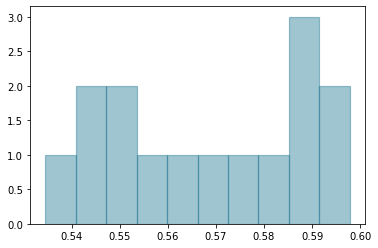